In [61]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

In [2]:
data = pd.read_csv('NF-ToN-IoT.csv')

In [3]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.1.195,63318,52.139.250.253,443,6,91.00,181,165,2,1,24,327,0,Benign
1,192.168.1.79,57442,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign
2,192.168.1.79,57452,239.255.255.250,15600,17,0.00,63,0,1,0,0,0,0,Benign
3,192.168.1.193,138,192.168.1.255,138,17,10.16,472,0,2,0,0,0,0,Benign
4,192.168.1.79,51989,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,192.168.1.31,58032,192.168.1.194,80,6,7.00,216,180,4,3,18,9433,1,ddos
1379270,192.168.1.31,58034,192.168.1.194,80,6,7.00,216,180,4,3,18,9221,1,ddos
1379271,192.168.1.31,58036,192.168.1.194,80,6,7.00,216,180,4,3,18,9656,1,ddos
1379272,192.168.1.31,58038,192.168.1.194,80,6,7.00,216,180,4,3,18,10046,1,ddos


In [4]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [5]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [6]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [7]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [8]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.21.71.96:63318,52.139.250.253:443,6,91.00,181,165,2,1,24,327,0,Benign
1,172.20.204.65:57442,192.168.1.255:15600,17,0.00,63,0,1,0,0,0,0,Benign
2,172.22.97.207:57452,239.255.255.250:15600,17,0.00,63,0,1,0,0,0,0,Benign
3,172.17.112.113:138,192.168.1.255:138,17,10.16,472,0,2,0,0,0,0,Benign
4,172.16.58.135:51989,192.168.1.255:15600,17,0.00,63,0,1,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,172.18.152.95:58032,192.168.1.194:80,6,7.00,216,180,4,3,18,9433,1,ddos
1379270,172.29.52.96:58034,192.168.1.194:80,6,7.00,216,180,4,3,18,9221,1,ddos
1379271,172.27.238.17:58036,192.168.1.194:80,6,7.00,216,180,4,3,18,9656,1,ddos
1379272,172.28.160.92:58038,192.168.1.194:80,6,7.00,216,180,4,3,18,10046,1,ddos


In [9]:
data.drop(columns=['Attack'],inplace = True)

In [10]:
data.rename(columns={"Label": "label"},inplace = True)

In [11]:
label = data.label

In [12]:
data.drop(columns=['label'],inplace = True)

In [13]:
scaler = StandardScaler()

In [14]:
data =  pd.concat([data, label], axis=1)

In [15]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
0,172.21.71.96:63318,52.139.250.253:443,6,91.00,181,165,2,1,24,327,0
1,172.20.204.65:57442,192.168.1.255:15600,17,0.00,63,0,1,0,0,0,0
2,172.22.97.207:57452,239.255.255.250:15600,17,0.00,63,0,1,0,0,0,0
3,172.17.112.113:138,192.168.1.255:138,17,10.16,472,0,2,0,0,0,0
4,172.16.58.135:51989,192.168.1.255:15600,17,0.00,63,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1379269,172.18.152.95:58032,192.168.1.194:80,6,7.00,216,180,4,3,18,9433,1
1379270,172.29.52.96:58034,192.168.1.194:80,6,7.00,216,180,4,3,18,9221,1
1379271,172.27.238.17:58036,192.168.1.194:80,6,7.00,216,180,4,3,18,9656,1
1379272,172.28.160.92:58038,192.168.1.194:80,6,7.00,216,180,4,3,18,10046,1


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [17]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [18]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [19]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
1136181,172.27.155.212:46172,192.168.1.194:80,0.305473,0.583457,-0.007181,-0.025163,-0.004989,-0.008516,0.466183,0.029279,1
618165,172.23.206.154:49662,192.168.1.195:80,0.305473,0.583457,-0.005863,-0.005514,-0.004667,-0.005293,0.485718,-0.052318,1
1049352,172.18.28.97:443,192.168.1.30:41844,0.305473,-0.650380,-0.008074,-0.025817,-0.005957,-0.009591,-2.607223,-0.054776,0
1138369,172.17.99.26:80,192.168.1.31:38866,0.305473,0.583457,-0.008074,-0.025817,-0.005957,-0.009591,-2.607223,-0.055219,0
116060,172.20.162.111:40068,192.168.1.190:80,0.305473,0.583457,-0.005373,-0.004783,-0.004667,-0.004218,0.485718,-0.054358,1
...,...,...,...,...,...,...,...,...,...,...,...
934717,172.18.236.87:47960,192.168.1.184:443,0.305473,-0.650380,-0.007747,-0.025740,-0.005635,-0.009591,0.466183,-0.055286,1
549787,172.23.5.99:55448,192.168.1.184:443,0.305473,-0.650380,-0.002639,-0.005014,-0.003699,-0.002069,0.579017,-0.054300,1
566730,172.22.199.18:44906,52.59.177.21:80,0.305473,0.745102,-0.005449,0.096934,-0.004344,0.002229,0.485718,-0.041907,1
1240787,172.16.161.74:56578,192.168.1.184:443,0.305473,-0.650380,-0.007747,-0.025740,-0.005635,-0.009591,0.466183,-0.055286,1


In [20]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [21]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [22]:
G = G.to_directed()


In [23]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [24]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [25]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [26]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [27]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [28]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        self.W_apply = nn.Linear(ndim_in + edims, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m':  edges.data['h'] }

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [29]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [30]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [31]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 2)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [80]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(G.edata['label'].cpu().numpy()),
                                                 G.edata['label'].cpu().numpy())

In [81]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [35]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [36]:
G.ndata['h'].device


device(type='cuda', index=0)

In [37]:
G.edata['h'].device


device(type='cuda', index=0)

In [82]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,20000):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Training acc: 0.9556666016578674
Training acc: 0.956838071346283
Training acc: 0.9754611849784851
Training acc: 0.9739500880241394
Training acc: 0.9744213223457336
Training acc: 0.9794814586639404
Training acc: 0.9844892621040344
Training acc: 0.990038275718689
Training acc: 0.9919476509094238
Training acc: 0.9920507073402405
Training acc: 0.9917658567428589
Training acc: 0.9937198162078857
Training acc: 0.99267578125
Training acc: 0.9931594729423523
Training acc: 0.9935457706451416
Training acc: 0.9935540556907654
Training acc: 0.9949637055397034
Training acc: 0.9957457184791565
Training acc: 0.995270848274231
Training acc: 0.9950813055038452
Training acc: 0.9958264827728271
Training acc: 0.9953888654708862
Training acc: 0.9946452379226685
Training acc: 0.9957317113876343
Training acc: 0.9963982105255127
Training acc: 0.9951449632644653
Training acc: 0.9963365793228149
Training acc: 0.996349036693573
Training acc: 0.9969777464866638
Training acc: 0.9972475171089172
Training acc: 0.997

In [39]:
X_test = encoder.transform(X_test)

In [40]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [41]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
1212302,172.23.149.141:59622,192.168.1.184:443,0.305473,-0.650380,-0.007747,-0.025740,-0.005635,-0.009591,0.466183,-0.055286,1
319684,172.23.37.68:38636,52.59.177.21:80,0.305473,0.745102,-0.005689,0.096934,-0.004667,0.002229,0.485718,-0.042802,1
161128,172.28.125.52:50748,192.168.1.152:80,0.305473,0.583457,-0.005531,0.009846,-0.004667,-0.004218,0.485718,-0.054768,1
809034,172.22.89.90:59096,91.189.91.139:53,-2.765838,-3.838612,-0.007960,-0.025028,-0.005957,-0.009591,-1.149118,-0.052886,0
1003939,172.26.73.154:46164,192.168.1.190:80,0.305473,0.583457,-0.007747,-0.025740,-0.005635,-0.009591,0.466183,-0.055286,1
...,...,...,...,...,...,...,...,...,...,...,...
569840,172.20.147.103:59240,192.168.1.152:80,0.305473,0.583457,-0.005138,0.009846,-0.004667,-0.004218,0.485718,-0.053689,1
590187,172.25.2.74:42914,192.168.1.190:80,0.305473,0.583457,-0.005623,-0.004783,-0.004667,-0.004218,0.485718,-0.051916,1
1112800,172.21.235.155:58262,192.168.1.184:443,0.305473,-0.650380,-0.007747,-0.025740,-0.005635,-0.009591,0.466183,-0.055286,1
174527,172.25.250.120:36724,192.168.1.195:80,0.305473,0.583457,-0.005863,-0.005514,-0.004667,-0.005293,0.485718,-0.053121,1


In [42]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [91]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [92]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [93]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [94]:
G_test = G_test.to('cuda:0')


In [95]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [96]:
print(str(elapsed) + ' seconds')


0.05728961600107141 seconds


In [97]:
test_pred = test_pred.argmax(1)


In [98]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [99]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [100]:
from sklearn.metrics import plot_confusion_matrix


In [101]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

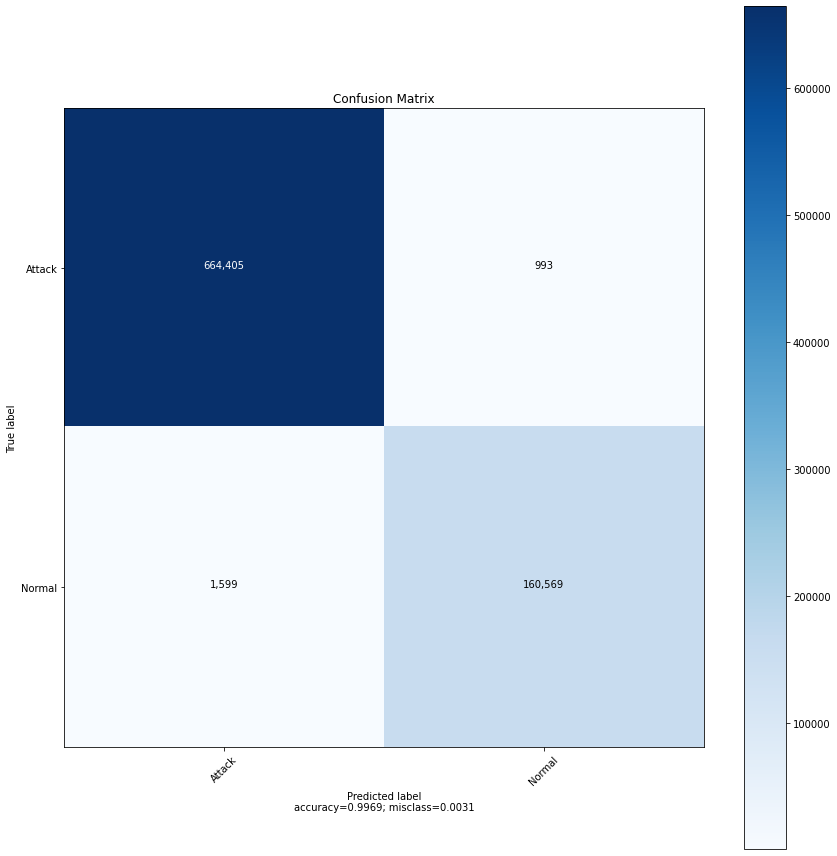

In [102]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [116]:
from sklearn.metrics import classification_report
print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9939    0.9901    0.9920    162168
           1     0.9976    0.9985    0.9981    665398

    accuracy                         0.9969    827566
   macro avg     0.9957    0.9943    0.9950    827566
weighted avg     0.9969    0.9969    0.9969    827566



In [117]:
report = classification_report(actual, test_pred, digits=4, output_dict=True)

In [118]:
df = pd.DataFrame(report).transpose()

In [119]:
df.to_csv('unsw_ton_iot_binary_mean_agg_report.csv')

In [120]:
th.save(model.state_dict(), 'unsw_ton_iot_binary_mean_agg.pt')

In [108]:
actual = [0 if i == "Normal" else 1 for i in actual]
test_pred = [0 if i == "Normal" else 1 for i in test_pred]